In [1]:
import pandas as pd
import os 
import glob
import re
import datetime as dt

#os.chdir('./nishika_conpe/hand_apartment')
os.getcwd()

'/Users/hayashidanaoki/jupyter_home/nishika_conpe/hand_apartment'

## データ読み取り

In [68]:
train_df = pd.DataFrame()
for i in glob.glob('./input/train/*.csv'):
    temp = pd.read_csv(i)
    train_df = train_df.append(temp)
    
test_df = pd.read_csv('./input/test.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 ## 前処理

In [165]:
def processing_job(df):
    #列名変更
    renmae_dict ={ '種類':'type', '地域':'area_name', '市区町村コード':'municipality_code', 
              '都道府県名':'prefectures_name', '市区町村名':'municipality_name'
              , '地区名':'district_name', '最寄駅：名称':'nearest_station_name', 
              '最寄駅：距離（分）':'nearest_station_distance', '間取り':'floor_plan', 
              '面積（㎡）':'room_area', '土地の形状':'area_shape', '間口':'frontage', 
              '延床面積（㎡）':'total_floor_area', '建築年':'construction_year', 
              '建物の構造':'construction', '用途':'opt', '今後の利用目的':'next_opt', 
              '前面道路：方位':'load_direction', '前面道路：種類':'load_type', 
              '前面道路：幅員（ｍ）':'load_width', '都市計画':'city_plan', '建ぺい率（％）':'building_coverage_ratio', 
              '容積率（％）':'floor_area_ratio', '取引時点':'trading_date', '改装':'rehome_flg', 
              '取引の事情等':'trading_reason', '取引価格（総額）_log':'trading_price_log'}
    df = df.rename(columns=renmae_dict)
    
    #最寄駅：距離（分）　異常値加工
    df['nearest_station_distance'] = df['nearest_station_distance'].replace('1H30?2H','105').replace('1H?1H30','75').replace('2H?','120').replace('30分?60分','45')
    df['nearest_station_distance'] = df['nearest_station_distance'].fillna(0)
    
    #数値データnull → 0
    df['building_coverage_ratio'] = df['building_coverage_ratio'].fillna(0)
    df['floor_area_ratio'] = df['floor_area_ratio'].fillna(0)
    
    #築年数カラム作成
    df['wareki'] = df['construction_year'].str[:2]
    wareki_dict = {'戦前':'1900', '昭和':'1926', '平成':'1989', '令和':'2019'}
    df['wareki_year'] = df['wareki'].map(wareki_dict)
    df['year'] = df['construction_year'].str[2:-1]
    df['year'] = df['year'].replace('',0)
    df['construction_age'] = df['wareki_year'].fillna(0).astype('int') + df['year'].fillna(0).astype('int')
    
    #都道府県ラベル化
    area_japan = {"北海道": 1, "青森県": 2, "岩手県": 3, "宮城県": 4, "秋田県": 5, "山形県": 6, 
              "福島県": 7, "茨城県": 8, "栃木県": 9, "群馬県": 10, "埼玉県": 11, "千葉県": 12, 
              "東京都": 13, "神奈川県": 14, "新潟県": 15, "富山県": 16, "石川県": 17, "福井県": 18,
              "山梨県": 19, "長野県": 20, "岐阜県": 21, "静岡県": 22, "愛知県": 23, "三重県": 24,
              "滋賀県": 25, "京都府": 26, "大阪府": 27, "兵庫県": 28, "奈良県": 29, "和歌山県": 30,
              "鳥取県": 31, "島根県": 32, "岡山県": 33, "広島県": 34, "山口県": 35, "徳島県": 36,
              "香川県": 37, "愛媛県": 38, "高知県": 39, "福岡県": 40, "佐賀県": 41, "長崎県": 42,
              "熊本県": 43, "大分県": 44, "宮崎県": 45, "鹿児島県": 46, "沖縄県": 47
    }
    df['prefectures_name'] = df['prefectures_name'].map(area_japan)
    
    #面積　2000㎡以上　→ 2000
    df['room_area'] = df['room_area'].replace('2000㎡以上',2000)
    
    #取引経過日数カラム作成
    df['now_yaer'] = pd.to_datetime(dt.date.today())
    df['trading_yaer'] = pd.to_datetime(df['trading_date'].str[:4], format='%Y')
    df['trading_elapsed_date'] = df['now_yaer'] - df['trading_yaer']
    df['trading_elapsed_date'] = df['trading_elapsed_date'].dt.days
    
    #不要カラム削除
    drop_columns = ['ID','type','area_name','municipality_code','municipality_name','district_name','nearest_station_name',
                'area_shape','frontage','total_floor_area','construction_year','load_direction',
                'load_type','load_width','trading_date','wareki','wareki_year','year','now_yaer','trading_yaer']
    df = df.drop(drop_columns, axis=1)
    
    return df

In [166]:
train_df_processing = processing_job(train_df)
test_df_processing = processing_job(test_df)


In [167]:
# 結合する（一応フラグを付けるが大抵はTargetの有無で判別できる）
train_df_processing['isTrain'] = True
test_df_processing['isTrain'] = False
df = pd.concat([train_df_processing, test_df_processing])

#ダミー変数化
dummy_target = ['floor_plan','construction','opt','next_opt','city_plan','rehome_flg','trading_reason']
for i in dummy_target:
    df = pd.concat([df, pd.get_dummies(df[i])], axis=1)
#不要カラム削除
df = df.drop(dummy_target, axis=1)

#nanを一つでも含むレコードを削除
#df = df.dropna(axis = 0, how = 'any')

#再度分離
train = df.loc[df.isTrain].drop('isTrain', axis=1)
test = df.loc[~df.isTrain].drop('isTrain', axis=1)

## 学習

In [168]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

In [228]:
X_train = train.drop("trading_price_log", axis=1)
Y_train = train["trading_price_log"]

X_test = test.drop("trading_price_log", axis=1)

In [181]:
# データセットを分割する関数の読み込み
from sklearn.model_selection import train_test_split

# 訓練用データセットとテスト用データセットへの分割
x_train, x_test, t_train, t_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [183]:
model = linear_model.LinearRegression()

In [184]:
model.fit(x_train, t_train)

LinearRegression()

## 検証データ評価

In [185]:
mean_squared_error(t_test ,model.predict(x_test))

0.08197689430484291

In [186]:
# 偏回帰係数
coef_out = pd.DataFrame({"Name":X_train.columns,
                    "Coefficients":model.coef_}).sort_values(by='Coefficients')
print(coef_out)
coef_out.to_csv('./output/Coefficients.csv')

       Name  Coefficients
101  店舗、その他     -4.101226
103  駐車場、店舗     -3.146027
98   倉庫、駐車場     -1.552998
99       工場     -1.092540
84   事務所、倉庫     -0.838474
..      ...           ...
23       ２Ｄ      0.284342
52       ４Ｌ      0.305479
76    ＲＣ、木造      0.362015
16     １Ｌ＋Ｓ      0.385494
30      ２ＬＤ      0.432166

[135 rows x 2 columns]


In [187]:
model.coef_

array([-5.78578522e-03, -5.88201451e-03,  5.45288108e-03, -2.71586118e-03,
        9.46321043e-04,  3.25423023e-05, -4.31519681e-06, -6.87580478e-02,
        2.27622306e-01,  1.50035116e-01, -2.59278206e-02, -2.32020524e-01,
       -2.90811431e-02, -3.51462896e-02,  4.79750035e-02, -2.40399769e-01,
        3.85494134e-01,  2.10345840e-01,  1.49393786e-01,  1.80236635e-01,
       -1.08669306e-01, -1.89799517e-01,  1.00892896e-01,  2.84342409e-01,
       -5.30360741e-02, -2.34050883e-02, -7.82827951e-02, -1.16920322e-01,
        7.17423806e-02,  1.76469092e-01,  4.32165988e-01,  1.02149618e-01,
        1.06617982e-01,  6.00367575e-02,  1.27704103e-01,  2.86265757e-02,
        8.95988697e-02, -2.81099853e-02, -1.51110520e-01, -1.46415575e-01,
       -2.65786271e-01, -2.03328538e-01, -9.55674980e-02,  1.22283832e-01,
        8.95741100e-02,  1.64983470e-01,  1.03223609e-01, -1.39383684e-01,
        1.48176926e-02, -2.15148689e-01, -2.06814494e-01, -2.51561329e-01,
        3.05479145e-01, -

In [188]:
model.intercept_

6.915235445581961

In [189]:
#決定係数出力
model.score(x_train,t_train)

0.38838201308538545

## テストデータ評価

In [194]:
Y_test = model.predict(X_test)

In [195]:
X_test['取引価格（総額）_log'] = Y_test



In [201]:
#提出データ
pd.concat([test_df['ID'],X_test['取引価格（総額）_log']], axis=1).to_csv('./output/submission.csv', index = False)

## リッジ回帰

In [180]:
from sklearn.linear_model import Ridge

In [217]:
list_alpha = [n*0.1 for n in range(1, 101)]
list_coef = []
list_score = []

for n_alpha in list_alpha:
    print(n_alpha)
    # Ridge
    ridge = Ridge(alpha=n_alpha)
    ridge.fit(x_train, t_train)

    # 予測　
    ridge_pred = ridge.predict(x_test)

    # スコア
    score = ridge.score(x_test, t_test)
    
    list_coef.append(ridge.coef_)
    list_score.append(score)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
7.5
7.6000000000000005
7.7
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.600000000000001
9.700000000000001
9.8
9.9
10.0


In [229]:
X_test.head()

,prefectures_name,nearest_station_distance,room_area,building_coverage_ratio,floor_area_ratio,construction_age,trading_elapsed_date,オープンフロア,スタジオ,メゾネット,...,未改装,その他事情有り,他の権利・負担付き,他の権利・負担付き、調停・競売等,瑕疵有りの可能性,調停・競売等,調停・競売等、瑕疵有りの可能性,関係者間取引,関係者間取引、瑕疵有りの可能性,関係者間取引、調停・競売等
0,1,26,75,40.0,60.0,1990,466,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,2,45,80.0,400.0,1992,466,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,2,50,80.0,400.0,1990,466,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,80,80.0,400.0,1998,466,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3,20,80.0,400.0,1982,466,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [205]:
import matplotlib.pyplot as plt

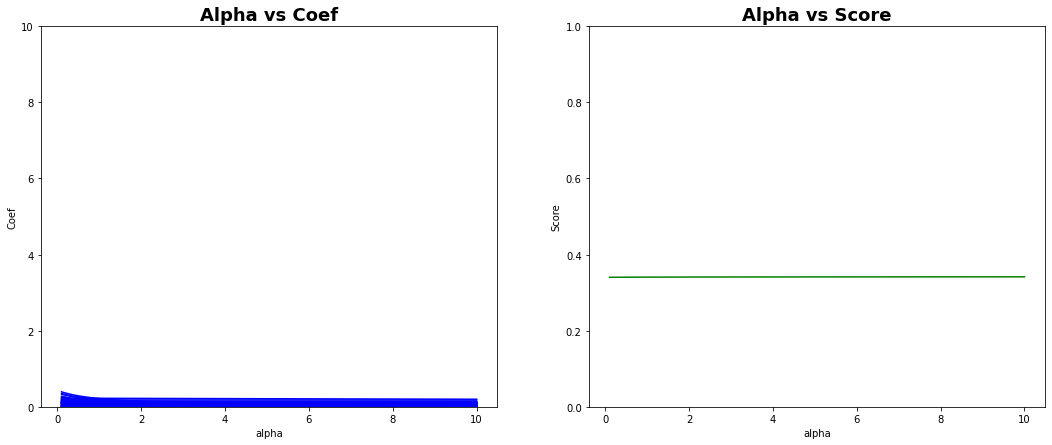

In [219]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title("Alpha vs Coef", fontweight="bold", size=18)
plt.xlabel("alpha")
plt.ylabel("Coef")
plt.ylim(0, 10)
plt.plot(list_alpha, list_coef, "-b")

plt.subplot(1, 2, 2)
plt.title("Alpha vs Score", fontweight="bold", size=18)
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.plot(list_alpha, list_score, "-g")
plt.show()

In [220]:
mean_squared_error(t_test ,ridge.predict(x_test))

0.08181711071479587

array([7.43094507, 7.3298203 , 7.35124693, ..., 6.93785394, 7.15715424,
       6.86181904])

In [234]:
result_ridge = pd.DataFrame(ridge.predict(X_test), columns=['取引価格（総額）_log'])
pd.concat([test_df['ID'],result_ridge['取引価格（総額）_log']], axis=1).to_csv('./output/ridge_submission.csv', index = False)

In [233]:
pd.DataFrame(ridge.predict(X_test), columns=['取引価格（総額）_log'])

,取引価格（総額）_log
0,7.430945
1,7.329820
2,7.351247
3,7.627917
4,7.161137
...,...
17889,7.146346
17890,7.074657
17891,6.937854
17892,7.157154
